# **Understanding Western Architecutural Styles Through Deep Learning**

## **Connect the colab operation environment with google drive**

In this project, we upload the data onto google drive which makes it much easier to reuse. You can find the data in my GitHub Repository.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Show some info about the dataset (You should modify the data path according to your google drive path):

In [4]:
import os

byzantine_dir = os.path.join('/content/drive/MyDrive/Self/BuildingStyleDataset/Byzantine_Data')
classic_dir = os.path.join('/content/drive/MyDrive/Self/BuildingStyleDataset/Classic_Data')
gothic_dir = os.path.join('/content/drive/MyDrive/Self/BuildingStyleDataset/Gothic_Data')

print('total training images for Byzantine Style Building:', len(os.listdir(byzantine_dir)))
print('total training images for Classic Style Building:', len(os.listdir(classic_dir)))
print('total training images for Gothic Style Building:', len(os.listdir(gothic_dir)))

total training images for Byzantine Style Building: 79
total training images for Classic Style Building: 90
total training images for Gothic Style Building: 100


Display some of the images

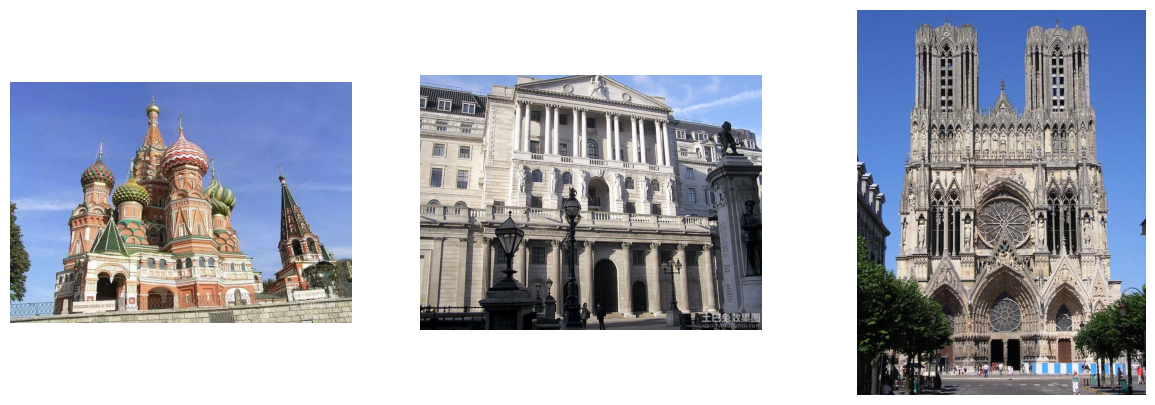

In [5]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 1

next_byzantine = [os.path.join(byzantine_dir, fname)
                  for fname in os.listdir(byzantine_dir)[0:pic_index]]
next_classic = [os.path.join(classic_dir, fname)
                for fname in os.listdir(classic_dir)[0:pic_index]]
next_gothic = [os.path.join(gothic_dir, fname)
               for fname in os.listdir(gothic_dir)[0:pic_index]]

# Create a figure with a single row and three columns
plt.figure(figsize=(15, 5))  # Adjust the size as needed

# List of all images
all_images = next_byzantine + next_classic + next_gothic

# Loop through the images, creating a subplot for each one
for i, img_path in enumerate(all_images):
    img = mpimg.imread(img_path)
    plt.subplot(1, 3, i + 1)  # (1 row, 3 columns, index of subplot to fill next)
    plt.imshow(img)
    plt.axis('off')  # Correct syntax to remove axes

plt.show()


# **Split the dataset into training part and validating part**

In [6]:
import glob
from PIL import Image
from tqdm import tqdm

raw_data_dirs = {'byzantine': byzantine_dir,'classic':classic_dir,'gothic':gothic_dir}

def split_images(origin_dir,class_name, train_dir,test_dir,train_ratio):
    if not (os.path.exists(train_dir + f'/{class_name}/')):
      os.makedirs(train_dir + f'/{class_name}/')
    if not (os.path.exists(test_dir + f'/{class_name}/')):
      os.makedirs(test_dir + f'/{class_name}/')
    # Read all the images with the jpg
    images = glob.glob(origin_dir + '/*.jpg')
    # Calculate the number of training images
    num_images = len(images)
    num_train_images = int(train_ratio * num_images)
    # Iterate through all the images
    for i in tqdm(range(num_images), desc=f'Split Dataset for {class_name}: '):
        image_path = images[i]
        image = Image.open(image_path)
        if i < num_train_images:
            new_image_path = train_dir + f'/{class_name}/' + os.path.basename(image_path)
        else:
            new_image_path = test_dir + f'/{class_name}/' + os.path.basename(image_path)
        # Save the image
        image.save(new_image_path)

In [7]:
for k,v in raw_data_dirs.items():
  split_images(v,k,'./training','./validating',0.8)

Split Dataset for gothic: 100%|██████████| 99/99 [00:07<00:00, 13.42it/s]


### **Initialize Dataset**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Note: ImageDataGenerator in Keras implements "in-place" augementation - ie it replaces
# the batch of images past in with a transformed set.
# This means that when the network is trained, each Epoch sees new variations of our images
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

TRAINING_DIR = "/content/training/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Test with different data augmentation extend

weak_aug_training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

medium_aug_training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

strong_aug_training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)



VALIDATION_DIR = "/content/validating/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

print("Training data: ")
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=30
)

label_map = (train_generator.class_indices)
print("Classes found in data are: ", label_map)

print("Validation data: ")
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=30
)

Training data: 


FileNotFoundError: [Errno 2] No such file or directory: '/content/training/'

Next up we use a pretrained model as a starting point to build our new model.

Let's compare the pretrained model provided by TensorFlow Keras API

You can find the following data from https://keras.io/api/applications/

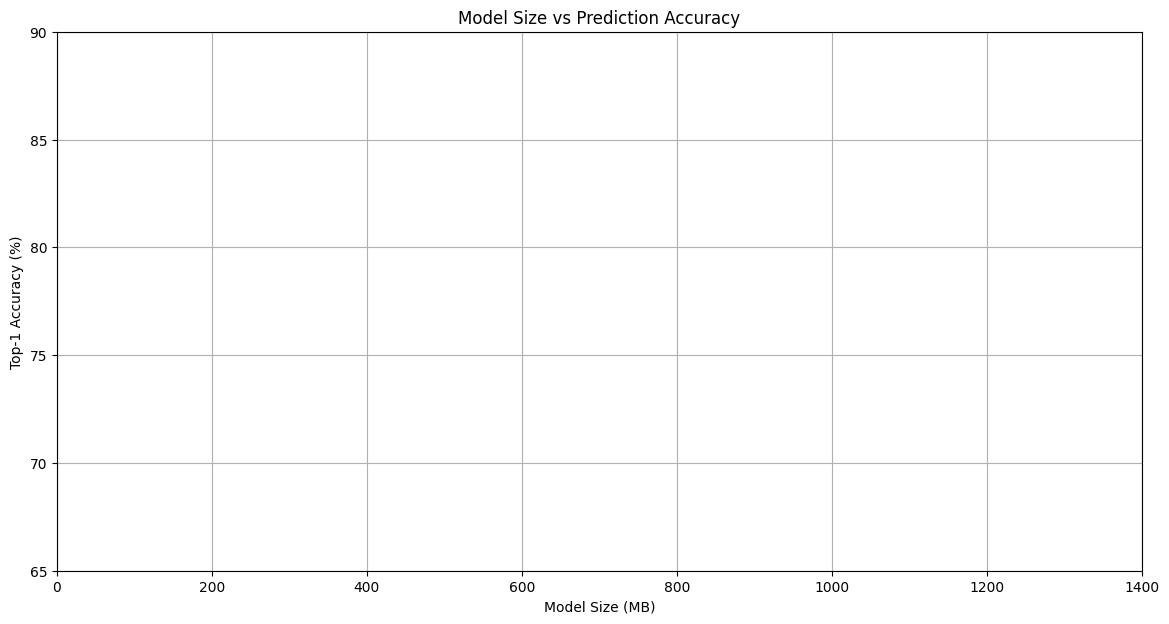

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

models = [
    "Xception", "VGG16", "VGG19", "ResNet50", "ResNet50V2", "ResNet101", "ResNet101V2", "ResNet152", "ResNet152V2",
    "InceptionV3", "InceptionResNetV2", "MobileNet", "MobileNetV2", "DenseNet121", "DenseNet169", "DenseNet201",
    "NASNetMobile", "NASNetLarge", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2", "EfficientNetB3",
    "EfficientNetB4", "EfficientNetB5", "EfficientNetB6", "EfficientNetB7", "EfficientNetV2B0", "EfficientNetV2B1",
    "EfficientNetV2B2", "EfficientNetV2B3", "EfficientNetV2S", "EfficientNetV2M", "EfficientNetV2L", "ConvNeXtTiny",
    "ConvNeXtSmall", "ConvNeXtBase", "ConvNeXtLarge", "ConvNeXtXLarge"
]
sizes = [
    88, 528, 549, 98, 98, 171, 171, 232, 232, 92, 215, 16, 14, 33, 57, 80, 23, 343, 29, 31, 36, 48, 75, 118, 166,
    256, 29, 34, 42, 59, 88, 220, 479, 109.42, 192.29, 338.58, 755.07, 1310
]
accuracies = [
    79.0, 71.3, 71.3, 74.9, 76.0, 76.4, 77.2, 76.6, 78.0, 77.9, 80.3, 70.4, 71.3, 75.0, 76.2, 77.3, 74.4, 82.5, 77.1,
    79.1, 80.1, 81.6, 82.9, 83.6, 84.0, 84.3, 78.7, 79.8, 80.5, 82.0, 83.9, 85.3, 85.7, 81.3, 82.3, 85.3, 86.3, 86.7
]
inference_times = [
    8.1, 4.2, 4.4, 4.6, 4.4, 5.2, 5.4, 6.5, 6.6, 6.9, 10.0, 3.4, 3.8, 5.4, 6.3, 6.7, 6.7, 20.0, 4.9, 5.6, 6.5, 8.8,
    15.1, 25.3, 40.4, 61.6, None, None, None, None, None, None, None, None, None, None, None, None
]

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_xlim(0, 1400)
ax.set_ylim(65, 90)
ax.set_title("Model Size vs Prediction Accuracy")
ax.set_xlabel("Model Size (MB)")
ax.set_ylabel("Top-1 Accuracy (%)")
ax.grid(True)

# Accumulated Data
data = []

# Update Function for Frame
def update(frame):
    data.append((sizes[frame], accuracies[frame]))
    ax.clear()
    ax.grid(True)
    ax.set_xlim(0, 1400)
    ax.set_ylim(65, 90)
    ax.set_title("Model Size vs Accuracy")
    ax.set_xlabel("Model Size (MB)")
    ax.set_ylabel("Accuracy(%)")
    ax.scatter(*zip(*data), color='black', alpha=0.75)
    for i in range(frame + 1):
        ax.annotate(models[i], (sizes[i], accuracies[i]),fontsize=8)

# Create Animation
ani = FuncAnimation(fig, update, frames=len(models), repeat=False)

# 显示动画
plt.show()

HTML(ani.to_html5_video())

# ani.save('model_size_accuracy_animation.gif', writer='imagemagick', fps=1)


In [40]:
import json

from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.densenet import DenseNet121
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.efficientnet_v2 import EfficientNetV2B1
from keras.applications.inception_v3 import InceptionV3

import tensorflow as tf


IMAGE_SIZE = [150, 150]

# Load the ResNet50 model with pretrained weights
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

# Make all layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = tf.keras.layers.Flatten()(base_model.output)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

### Test with different optimizer

# # Optimizer01 : Adam with default parameters
# optimizer_adam_default = tf.keras.optimizers.Adam()

# # Optimizer02 : SGD with default parameters
# optimizer_sgd_default = tf.keras.optimizers.SGD()

# # Optimizer03 : RMSprop with default parameters
# optimizer_rms_default = tf.keras.optimizers.RMSprop()

# # Optimizer04 : Adagrad with default parameters
# optimizer_adagrad_default = tf.keras.optimizers.Adagrad()

# Optimizer05 : AdaMax with default parameters
optimizer_adamax_default = tf.keras.optimizers.Adamax()

model.compile(
    optimizer=optimizer_adamax_default,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

for layer in model.layers:
    print(layer.name)

# ### Test on different learning rate

# learning_rates = [0.002, 0.001, 0.0005, 0.005, 0.01]
# optimizers = [tf.keras.optimizers.Adamax(learning_rate=lr) for lr in learning_rates]

# for i in range(len(optimizers)):
#   IMAGE_SIZE = [150, 150]

#   # Load the ResNet50 model with pretrained weights
#   base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

#   # Make all layers non-trainable
#   for layer in base_model.layers:
#       layer.trainable = False

#   # Add new layers
#   x = tf.keras.layers.Flatten()(base_model.output)
#   output = tf.keras.layers.Dense(3, activation='softmax')(x)

#   # Create the new model
#   model = Model(inputs=base_model.input, outputs=output)
#   model.compile(
#     optimizer=optimizers[i],
#     loss = 'categorical_crossentropy',
#     metrics=['accuracy']
#   )
#   history = model.fit(train_generator,
#                     epochs=20,
#                     validation_data = validation_generator,
#                     verbose = 1)


#   history_dict = history.history

#   # Save history data into json file
#   with open(f'densenet121_lrTest_{learning_rates[i]}.json', 'w') as f:
#       json.dump(history_dict, f)




87910968/87910968 [==============================] - 3s 0us/step


Finaly we can run our training:

In [41]:
# Test on the learning rate


# Run training and save to history so that we can plot metrics
history = model.fit(train_generator,
                    epochs=20,
                    validation_data = validation_generator,
                    verbose = 1)

# we can save the model so that we can reload at a later date
# It appears in the content folder - download it before your session ends
# https://www.tensorflow.org/guide/keras/save_and_serialize
# model.save("resnet50v2_default_test.h5")

Epoch 1/20
8/8 [==============================] - 14s 833ms/step - loss: 5.0357 - accuracy: 0.5000 - val_loss: 2.4005 - val_accuracy: 0.5556
Epoch 2/20
8/8 [==============================] - 3s 350ms/step - loss: 1.2844 - accuracy: 0.7243 - val_loss: 2.0753 - val_accuracy: 0.5556
Epoch 3/20
8/8 [==============================] - 2s 275ms/step - loss: 0.6641 - accuracy: 0.8318 - val_loss: 1.0396 - val_accuracy: 0.7407
Epoch 4/20
8/8 [==============================] - 2s 302ms/step - loss: 0.4842 - accuracy: 0.8645 - val_loss: 1.0941 - val_accuracy: 0.6852
Epoch 5/20
8/8 [==============================] - 2s 261ms/step - loss: 0.4461 - accuracy: 0.8738 - val_loss: 0.5546 - val_accuracy: 0.7778
Epoch 6/20
8/8 [==============================] - 3s 358ms/step - loss: 0.3958 - accuracy: 0.8925 - val_loss: 0.4171 - val_accuracy: 0.8519
Epoch 7/20
8/8 [==============================] - 2s 267ms/step - loss: 0.2664 - accuracy: 0.9065 - val_loss: 0.4128 - val_accuracy: 0.8148
Epoch 8/20
8/8 [===

1/1 [==============================] - 0s 25ms/step
Predicted class index: 1


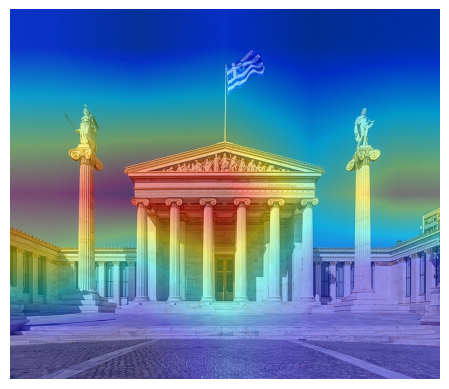

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load your image
img_path = 'classic_test.jpg'
img_array = get_img_array(img_path, size=IMAGE_SIZE)

# Make model
model.layers[-1].activation = None  # Remove softmax

# Print what the top predicted class is
preds = model.predict(img_array)
# Get the index of predictioin
predicted_class = np.argmax(preds[0])
print("Predicted class index:", predicted_class)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv5_block2_out')

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # 确保热力图尺寸与原图匹配
heatmap = np.uint8(255 * heatmap)  # 转换为0-255的范围
color_map = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # 应用色彩映射

# 创建透明度叠加的图像
superimposed_img = color_map * 0.4 + img * 0.6  # 调整这里的权重比例以改变透明度
superimposed_img = np.uint8(superimposed_img)  # 确保为整数类型

# 显示图像
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))  # 将BGR转换为RGB显示
plt.axis('off')  # 不显示坐标轴
plt.show()

# # 保存图像
# cv2.imwrite('img_with_heatmap.jpg', superimposed_img)

We can save all the training history data for future comparison

In [25]:
import json

history_dict = history.history

# Save history data into json file
with open('desnet121_BatchTest30_50Epoch.json', 'w') as f:
    json.dump(history_dict, f)

Once training is complete we can plot results - this should be starting to look familiar.

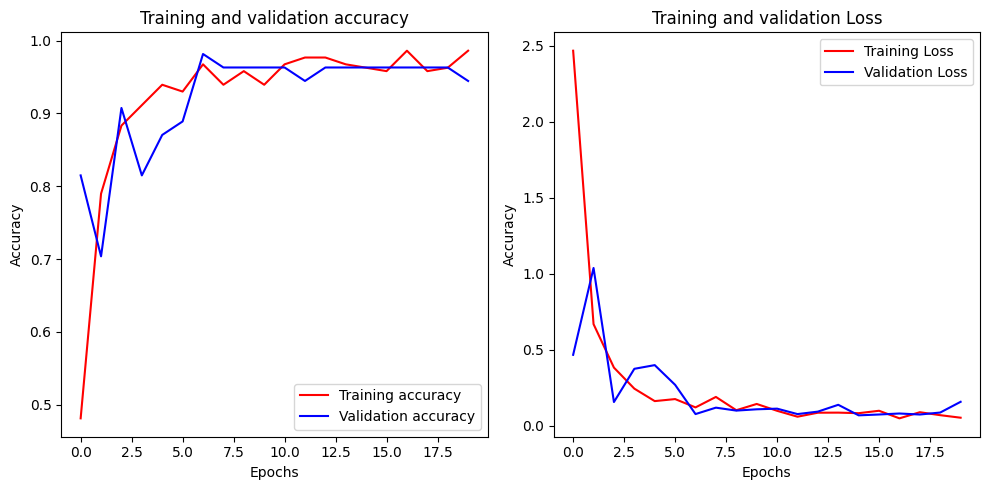

In [33]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()


# Testing your model
To see how well this model has learnt you can upload an image and classify it. Some sample images have been included in the github repo in a folder called testing. You can drag and drop those into the Contents folder on left panel.

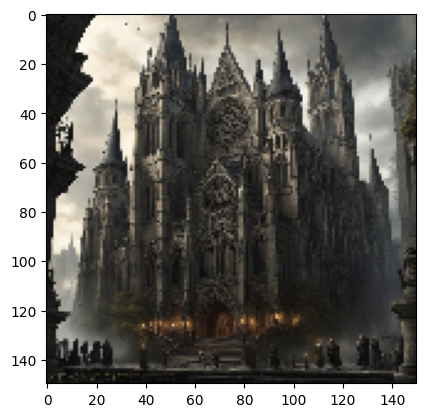

1/1 [==============================] - 0s 56ms/step
I think the image above is "classic" and I am 100.00% confident.
[1.7011815e-05 9.9998295e-01 4.5673684e-17]


<ipython-input-37-6e6099afb5c9>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('I think the image above is "%s" and I am %.2f%% confident.' % (predictions[0], p[0][predicted_class_indices]*100))


In [37]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# load an image from file
img = image.load_img('gothic_test3.jpeg', target_size=(150, 150))

plt.imshow(img)
plt.show()

# convert to an array that we can use as input to our model
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

# run prediction
p = model.predict(images)

# create a look up of the class labels generated from the
# "flow_from_directory" method used in the generator and print result
predicted_class_indices = np.argmax(model.predict(x), axis=-1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print('I think the image above is "%s" and I am %.2f%% confident.' % (predictions[0], p[0][predicted_class_indices]*100))

print(p[0])


## **Convert the Model into TensorFlow Lite Model**

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('archivision.tflite', 'wb') as f:
  f.write(tflite_model)